## Importing and Preprocessing

In [1]:
import pandas as pd
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import svm
from sklearn.model_selection import train_test_split  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
np.random.seed(1200)

In [45]:
def remove_single_letter_words(t):
    words = t.split()
    reformed = []
    for w in words:
        if len(w) > 1:
            reformed.append(w)
    t = " ".join(reformed)
    return t  

def dataclean(t):
    if pd.isna(t):
        t=""
    t = t.lower() # convert to lowercase
    t = re.sub('\\\\u[0-9A-Fa-f]{4}','', t) # remove NON- ASCII characters
    t = re.sub("[0-9]", "", t) # remove numbers # re.sub("\d+", "", t)
    t = re.sub('#', '', t) # remove '#'
    t=re.sub(r"<.*?>","",t) #html tags
    t = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', t) # remove links (URLs/ links)
    t = re.sub('[!"$%&\'()*+,-./:@;<=>?[\\]^_`{|}~]', '', t) # remove punctuations
    t = remove_single_letter_words(t) # removes single letter words
  
    return t

In [4]:
def preprocess(t):
    stop_words = set(stopwords.words('english'))
    lem = WordNetLemmatizer()
# tokenization
    tw = []  
    tw = word_tokenize(t)  

  # remove the stopwords
    fs = [] # filtered list after removing stop words
    fs = ([i for i in tw if i not in stop_words])

  # lemmatization  
    ns = []
    for i in fs:
        ns.append(lem.lemmatize(i, 'v')) # using verb POS
    ns = ' '.join(ns)
    return ns 

# UNSUMMARIZED REVIEWS

In [5]:
def classify_unsummarized(file):
    data=pd.read_csv(file)
    print(data['Topic'].value_counts())
    print('---------------------------------------')
    print(data['Review'][0])
    print('---------------------------------------')
    x = data['Review']
    y = data['Topic']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 1)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 1)
    print('Sizes of train,dev,test',x_train.shape,x_val.shape,x_test.shape)
    x_train = x_train.apply(dataclean)
    x_val = x_val.apply(dataclean)
    x_test = x_test.apply(dataclean)


    x_train=x_train.apply(preprocess)
    x_val=x_val.apply(preprocess)
    x_test=x_test.apply(preprocess)
    
    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(y_train)
    y_val= Encoder.transform(y_val)
    y_test= Encoder.transform(y_test)
    
    vectorizer = TfidfVectorizer()
    train_vectors = vectorizer.fit_transform(x_train)
    val_vectors = vectorizer.transform(x_val)
    test_vectors=vectorizer.transform(x_test)
    print("Naive Bayes Classifier")
    print('Validation Set')
    result=Naive_Bayes(train_vectors,y_train,val_vectors,y_val)
    print(result[0])
    print('Accuracy:',result[1])
    print('*****************************')
    print('Test Set')
    result=Naive_Bayes_test(test_vectors,y_test)
    print(result[0])
    print('Accuracy:',result[1])
    
    print('--------------------------------------------------------------------')
    print("Suport Vector Classifier")
    print('Validation Set')
    result=SVC(train_vectors,y_train,val_vectors,y_val)
    print(result[0])
    print('Accuracy:',result[1])
    print('*****************************')
    print('Test Set')
    result=SVC_test(test_vectors,y_test)
    print(result[0])
    print('Accuracy:',result[1])

def Naive_Bayes(x_train,y_train,x_val,y_val):
    global model_BNB
    model_BNB=BernoulliNB()
    model_BNB.fit(x_train,y_train)
    pred_NB=model_BNB.predict(x_val)

    confusion_mtx = confusion_matrix(y_val, pred_NB)
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for Naive Bayes(val)")
    plt.show()

    return classification_report(y_val,pred_NB),accuracy_score(y_val,pred_NB)

def Naive_Bayes_test(x_test,y_test):
    
    pred_NB_test=model_BNB.predict(x_test)

    confusion_mtx = confusion_matrix(y_test, pred_NB_test)
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for Naive Bayes(test)")
    plt.show()

    return classification_report(y_test,pred_NB_test),accuracy_score(y_test,pred_NB_test)
    
    
def SVC(x_train,y_train,x_val,y_val):
    global SVM
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(x_train,y_train)

    pred_SVM=SVM.predict(x_val)

    confusion_mtx = confusion_matrix(y_val, pred_SVM)
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for SVM(val)")
    plt.show()

    return classification_report(y_val,pred_SVM),accuracy_score(y_val,pred_SVM)

def SVC_test(x_test,y_test):
    
    pred_SVM_test=SVM.predict(x_test)

    confusion_mtx = confusion_matrix(y_test, pred_SVM_test)
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for SVM(test_set)")
    plt.show()

    return classification_report(y_test,pred_SVM_test),accuracy_score(y_test,pred_SVM_test)
    
    
    
    

Hotel          4211
Food           4000
Movies         4000
Electronics    3793
Name: Topic, dtype: int64
---------------------------------------
What first caught my attention of these bars were that they were vegan and soy free.  I have been trying to stay away from so much soy so I thought these bars would be a nice change of pace.  Upon opening this bar the smell was really nice.  I could smell peanuts but no chocolate smell was present.  I really loved the look of the bar, with all the seeds and such.  First bite I loved the texture, alot like the lara bars.  The taste was just so not what I expected, there wasn't any taste at all that I could even compare it to.  All I tasted to be honest was dates, no peanut butter or chocolate at all.  I was so dissapointed in this bar, I had such high hopes and expectations. I gave it two stars because the nutrition is there, but the flavor is not.  At over two bucks a bar at my local health food store, in no way is it worth it no matter how g

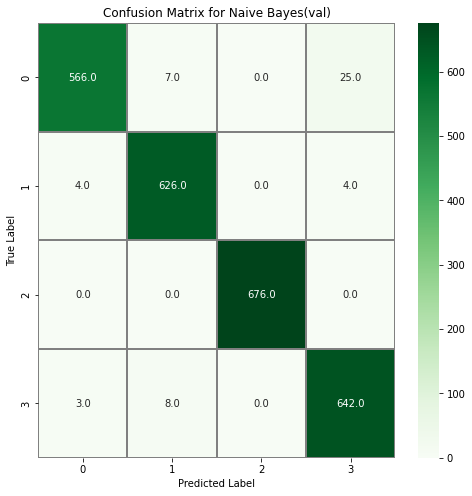

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       598
           1       0.98      0.99      0.98       634
           2       1.00      1.00      1.00       676
           3       0.96      0.98      0.97       653

    accuracy                           0.98      2561
   macro avg       0.98      0.98      0.98      2561
weighted avg       0.98      0.98      0.98      2561

Accuracy: 0.9800859039437719
*****************************
Test Set


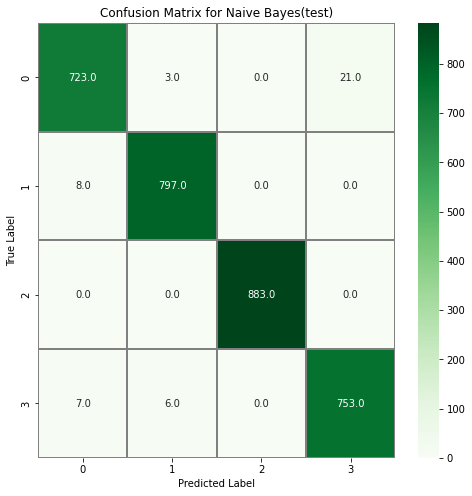

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       747
           1       0.99      0.99      0.99       805
           2       1.00      1.00      1.00       883
           3       0.97      0.98      0.98       766

    accuracy                           0.99      3201
   macro avg       0.99      0.99      0.99      3201
weighted avg       0.99      0.99      0.99      3201

Accuracy: 0.985941893158388
--------------------------------------------------------------------
Suport Vector Classifier
Validation Set


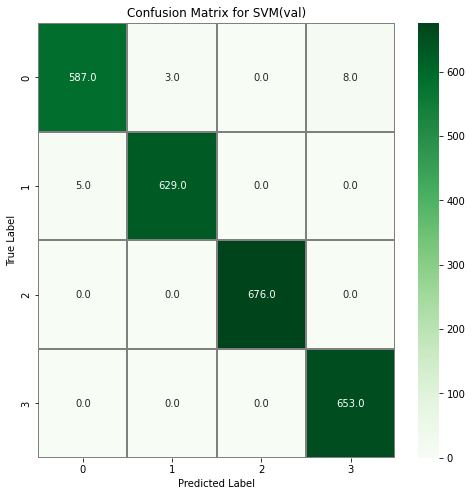

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       598
           1       1.00      0.99      0.99       634
           2       1.00      1.00      1.00       676
           3       0.99      1.00      0.99       653

    accuracy                           0.99      2561
   macro avg       0.99      0.99      0.99      2561
weighted avg       0.99      0.99      0.99      2561

Accuracy: 0.9937524404529481
*****************************
Test Set


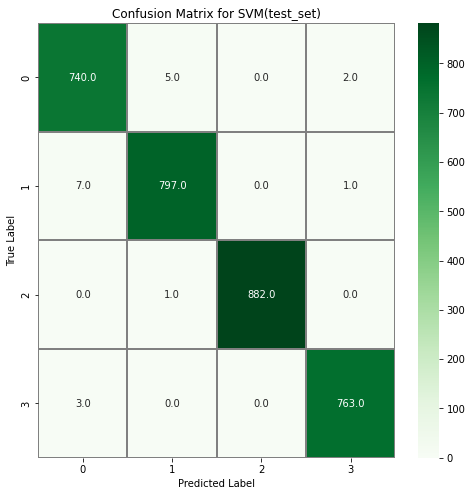

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       747
           1       0.99      0.99      0.99       805
           2       1.00      1.00      1.00       883
           3       1.00      1.00      1.00       766

    accuracy                           0.99      3201
   macro avg       0.99      0.99      0.99      3201
weighted avg       0.99      0.99      0.99      3201

Accuracy: 0.9940643548890972


In [6]:
file='final_unsummarized.csv'
classify_unsummarized(file)

# SUMMARIZED REVIEW CLASSFICATION

In [7]:
def classify_summarized(file):
    data=pd.read_csv(file)
    print('---------------------------------------')
    print(data['Review'][0])
    print('---------------------------------------')
    print(data['Summaries'][0])
    print('---------------------------------------')
    x = data['Summaries']
    y = data['Topic']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 1)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 1)
    print('Sizes of train,dev,test',x_train.shape,x_val.shape,x_test.shape)
    x_train = x_train.apply(dataclean)
    x_val = x_val.apply(dataclean)
    x_test = x_test.apply(dataclean)


    x_train=x_train.apply(preprocess)
    x_val=x_val.apply(preprocess)
    x_test=x_test.apply(preprocess)
    
    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(y_train)
    y_val= Encoder.transform(y_val)
    y_test= Encoder.transform(y_test)
    
    vectorizer = TfidfVectorizer()
    train_vectors = vectorizer.fit_transform(x_train)
    val_vectors = vectorizer.transform(x_val)
    test_vectors=vectorizer.transform(x_test)
    print("Naive Bayes Classifier")
    print('Validation Set')
    result=Naive_Bayes(train_vectors,y_train,val_vectors,y_val)
    print(result[0])
    print('Accuracy:',result[1])
    print('*****************************')
    print('Test Set')
    result=Naive_Bayes_test(test_vectors,y_test)
    print(result[0])
    print('Accuracy:',result[1])
    
    print('--------------------------------------------------------------------')
    print("Suport Vector Classifier")
    print('Validation Set')
    result=SVC(train_vectors,y_train,val_vectors,y_val)
    print(result[0])
    print('Accuracy:',result[1])
    print('*****************************')
    print('Test Set')
    result=SVC_test(test_vectors,y_test)
    print(result[0])
    print('Accuracy:',result[1])

def Naive_Bayes(x_train,y_train,x_val,y_val):
    global model_BNB
    model_BNB=BernoulliNB()
    model_BNB.fit(x_train,y_train)
    pred_NB=model_BNB.predict(x_val)

    confusion_mtx = confusion_matrix(y_val, pred_NB)
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for Naive Bayes(val)")
    plt.show()

    return classification_report(y_val,pred_NB),accuracy_score(y_val,pred_NB)

def Naive_Bayes_test(x_test,y_test):
    
    pred_NB_test=model_BNB.predict(x_test)

    confusion_mtx = confusion_matrix(y_test, pred_NB_test)
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for Naive Bayes(test)")
    plt.show()

    return classification_report(y_test,pred_NB_test),accuracy_score(y_test,pred_NB_test)
    
    
def SVC(x_train,y_train,x_val,y_val):
    global SVM
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(x_train,y_train)

    pred_SVM=SVM.predict(x_val)

    confusion_mtx = confusion_matrix(y_val, pred_SVM)
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for SVM(val)")
    plt.show()

    return classification_report(y_val,pred_SVM),accuracy_score(y_val,pred_SVM)

def SVC_test(x_test,y_test):
    
    pred_SVM_test=SVM.predict(x_test)

    confusion_mtx = confusion_matrix(y_test, pred_SVM_test)
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for SVM(test_set)")
    plt.show()

    return classification_report(y_test,pred_SVM_test),accuracy_score(y_test,pred_SVM_test)
    
    
    
    

### T5

---------------------------------------
What first caught my attention of these bars were that they were vegan and soy free.  I have been trying to stay away from so much soy so I thought these bars would be a nice change of pace.  Upon opening this bar the smell was really nice.  I could smell peanuts but no chocolate smell was present.  I really loved the look of the bar, with all the seeds and such.  First bite I loved the texture, alot like the lara bars.  The taste was just so not what I expected, there wasn't any taste at all that I could even compare it to.  All I tasted to be honest was dates, no peanut butter or chocolate at all.  I was so dissapointed in this bar, I had such high hopes and expectations. I gave it two stars because the nutrition is there, but the flavor is not.  At over two bucks a bar at my local health food store, in no way is it worth it no matter how good the nutrition is.  I will get my nutrition in a more delicious form. So if I were you I would purchase

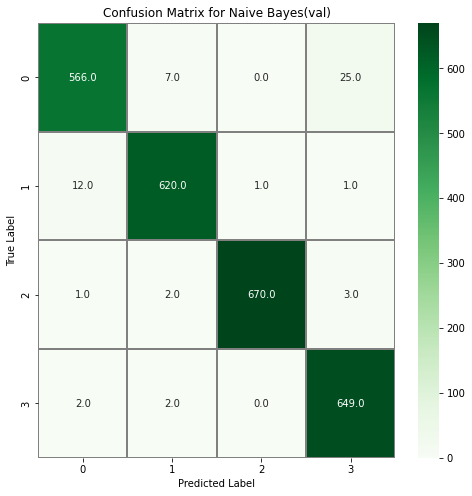

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       598
           1       0.98      0.98      0.98       634
           2       1.00      0.99      0.99       676
           3       0.96      0.99      0.98       653

    accuracy                           0.98      2561
   macro avg       0.98      0.98      0.98      2561
weighted avg       0.98      0.98      0.98      2561

Accuracy: 0.9781335415853183
*****************************
Test Set


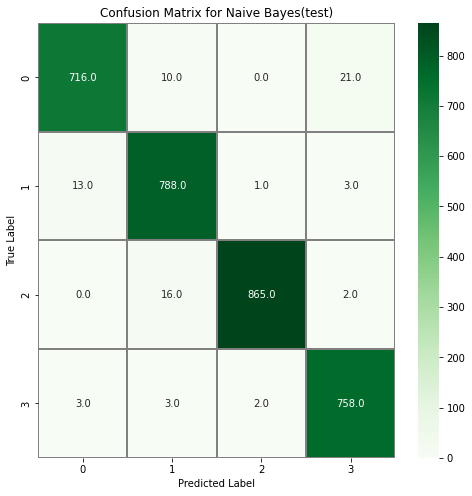

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       747
           1       0.96      0.98      0.97       805
           2       1.00      0.98      0.99       883
           3       0.97      0.99      0.98       766

    accuracy                           0.98      3201
   macro avg       0.98      0.98      0.98      3201
weighted avg       0.98      0.98      0.98      3201

Accuracy: 0.9768822243049047
--------------------------------------------------------------------
Suport Vector Classifier
Validation Set


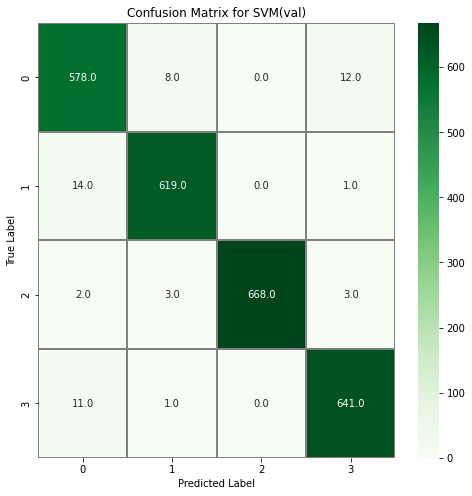

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       598
           1       0.98      0.98      0.98       634
           2       1.00      0.99      0.99       676
           3       0.98      0.98      0.98       653

    accuracy                           0.98      2561
   macro avg       0.98      0.98      0.98      2561
weighted avg       0.98      0.98      0.98      2561

Accuracy: 0.978524014057009
*****************************
Test Set


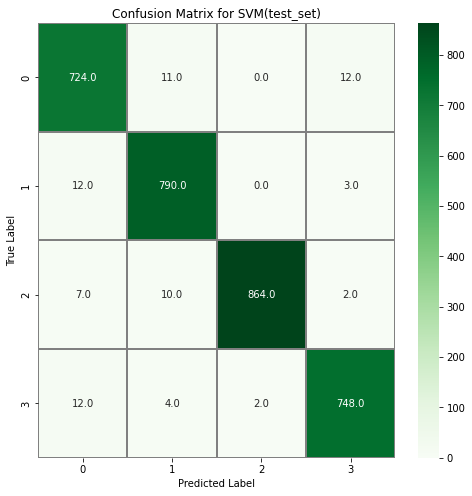

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       747
           1       0.97      0.98      0.98       805
           2       1.00      0.98      0.99       883
           3       0.98      0.98      0.98       766

    accuracy                           0.98      3201
   macro avg       0.98      0.98      0.98      3201
weighted avg       0.98      0.98      0.98      3201

Accuracy: 0.9765698219306467


In [8]:
file='final_summarized_T5.csv'
classify_summarized(file)

### BART

---------------------------------------
What first caught my attention of these bars were that they were vegan and soy free.  I have been trying to stay away from so much soy so I thought these bars would be a nice change of pace.  Upon opening this bar the smell was really nice.  I could smell peanuts but no chocolate smell was present.  I really loved the look of the bar, with all the seeds and such.  First bite I loved the texture, alot like the lara bars.  The taste was just so not what I expected, there wasn't any taste at all that I could even compare it to.  All I tasted to be honest was dates, no peanut butter or chocolate at all.  I was so dissapointed in this bar, I had such high hopes and expectations. I gave it two stars because the nutrition is there, but the flavor is not.  At over two bucks a bar at my local health food store, in no way is it worth it no matter how good the nutrition is.  I will get my nutrition in a more delicious form. So if I were you I would purchase

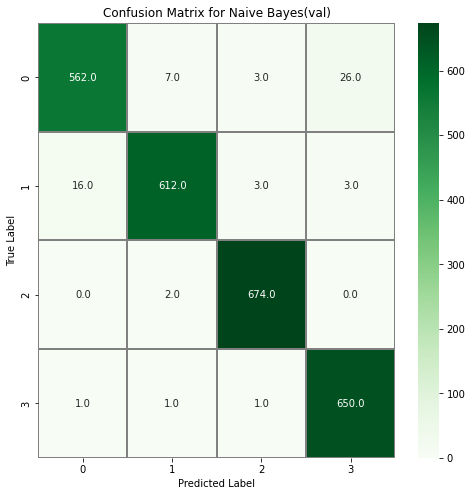

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       598
           1       0.98      0.97      0.97       634
           2       0.99      1.00      0.99       676
           3       0.96      1.00      0.98       653

    accuracy                           0.98      2561
   macro avg       0.98      0.97      0.97      2561
weighted avg       0.98      0.98      0.98      2561

Accuracy: 0.975400234283483
*****************************
Test Set


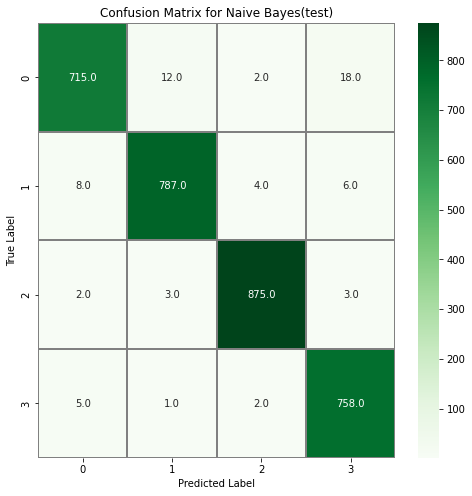

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       747
           1       0.98      0.98      0.98       805
           2       0.99      0.99      0.99       883
           3       0.97      0.99      0.98       766

    accuracy                           0.98      3201
   macro avg       0.98      0.98      0.98      3201
weighted avg       0.98      0.98      0.98      3201

Accuracy: 0.979381443298969
--------------------------------------------------------------------
Suport Vector Classifier
Validation Set


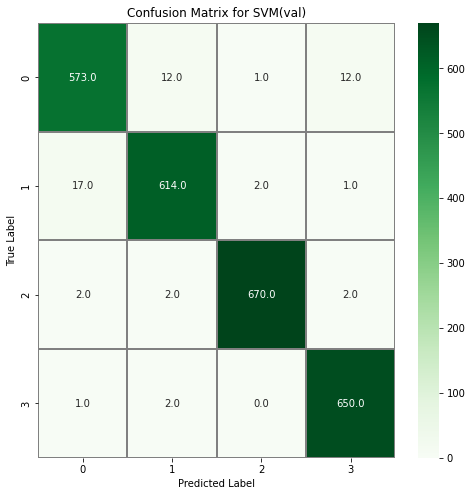

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       598
           1       0.97      0.97      0.97       634
           2       1.00      0.99      0.99       676
           3       0.98      1.00      0.99       653

    accuracy                           0.98      2561
   macro avg       0.98      0.98      0.98      2561
weighted avg       0.98      0.98      0.98      2561

Accuracy: 0.9789144865286997
*****************************
Test Set


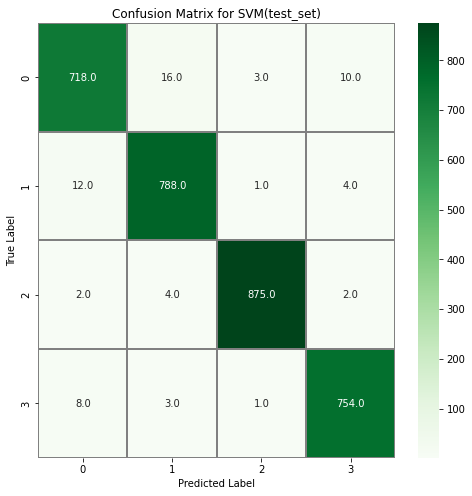

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       747
           1       0.97      0.98      0.98       805
           2       0.99      0.99      0.99       883
           3       0.98      0.98      0.98       766

    accuracy                           0.98      3201
   macro avg       0.98      0.98      0.98      3201
weighted avg       0.98      0.98      0.98      3201

Accuracy: 0.979381443298969


In [9]:
file='final_summarized_BART.csv'
classify_summarized(file)

### BERT with Blanks
- BERT genreated some summaries as blank probably indicating unknown words/acronyms

---------------------------------------
What first caught my attention of these bars were that they were vegan and soy free.  I have been trying to stay away from so much soy so I thought these bars would be a nice change of pace.  Upon opening this bar the smell was really nice.  I could smell peanuts but no chocolate smell was present.  I really loved the look of the bar, with all the seeds and such.  First bite I loved the texture, alot like the lara bars.  The taste was just so not what I expected, there wasn't any taste at all that I could even compare it to.  All I tasted to be honest was dates, no peanut butter or chocolate at all.  I was so dissapointed in this bar, I had such high hopes and expectations. I gave it two stars because the nutrition is there, but the flavor is not.  At over two bucks a bar at my local health food store, in no way is it worth it no matter how good the nutrition is.  I will get my nutrition in a more delicious form. So if I were you I would purchase

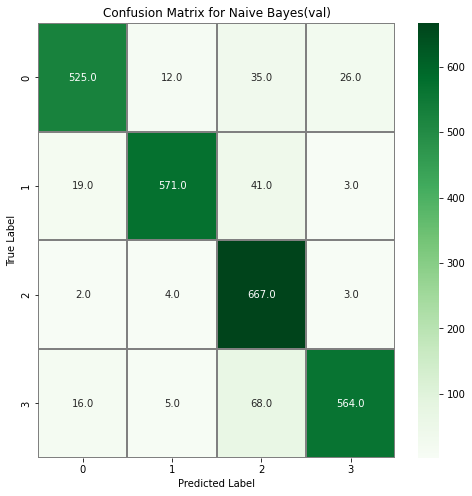

              precision    recall  f1-score   support

           0       0.93      0.88      0.91       598
           1       0.96      0.90      0.93       634
           2       0.82      0.99      0.90       676
           3       0.95      0.86      0.90       653

    accuracy                           0.91      2561
   macro avg       0.92      0.91      0.91      2561
weighted avg       0.92      0.91      0.91      2561

Accuracy: 0.9086294416243654
*****************************
Test Set


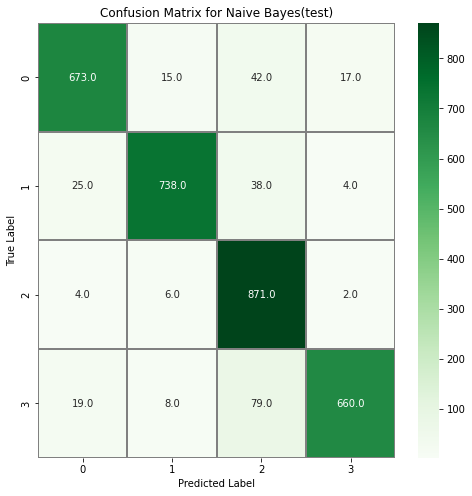

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       747
           1       0.96      0.92      0.94       805
           2       0.85      0.99      0.91       883
           3       0.97      0.86      0.91       766

    accuracy                           0.92      3201
   macro avg       0.93      0.92      0.92      3201
weighted avg       0.92      0.92      0.92      3201

Accuracy: 0.9190877850671665
--------------------------------------------------------------------
Suport Vector Classifier
Validation Set


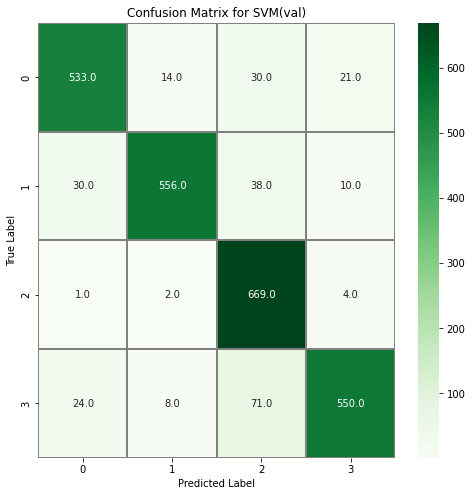

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       598
           1       0.96      0.88      0.92       634
           2       0.83      0.99      0.90       676
           3       0.94      0.84      0.89       653

    accuracy                           0.90      2561
   macro avg       0.91      0.90      0.90      2561
weighted avg       0.91      0.90      0.90      2561

Accuracy: 0.9012104646622413
*****************************
Test Set


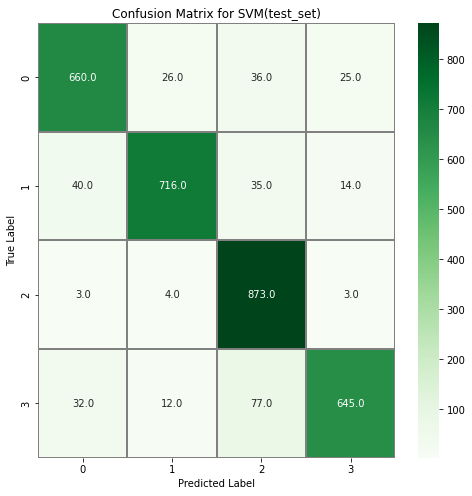

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       747
           1       0.94      0.89      0.92       805
           2       0.86      0.99      0.92       883
           3       0.94      0.84      0.89       766

    accuracy                           0.90      3201
   macro avg       0.91      0.90      0.90      3201
weighted avg       0.91      0.90      0.90      3201

Accuracy: 0.9040924711027803


In [46]:
file='final_summarized_BERT.csv'
classify_summarized(file)

### BERT with blanks replaced with original reviews


---------------------------------------
What first caught my attention of these bars were that they were vegan and soy free.  I have been trying to stay away from so much soy so I thought these bars would be a nice change of pace.  Upon opening this bar the smell was really nice.  I could smell peanuts but no chocolate smell was present.  I really loved the look of the bar, with all the seeds and such.  First bite I loved the texture, alot like the lara bars.  The taste was just so not what I expected, there wasn't any taste at all that I could even compare it to.  All I tasted to be honest was dates, no peanut butter or chocolate at all.  I was so dissapointed in this bar, I had such high hopes and expectations. I gave it two stars because the nutrition is there, but the flavor is not.  At over two bucks a bar at my local health food store, in no way is it worth it no matter how good the nutrition is.  I will get my nutrition in a more delicious form. So if I were you I would purchase

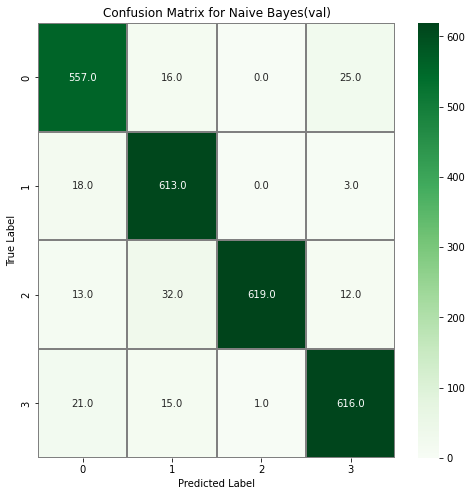

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       598
           1       0.91      0.97      0.94       634
           2       1.00      0.92      0.96       676
           3       0.94      0.94      0.94       653

    accuracy                           0.94      2561
   macro avg       0.94      0.94      0.94      2561
weighted avg       0.94      0.94      0.94      2561

Accuracy: 0.9390862944162437
*****************************
Test Set


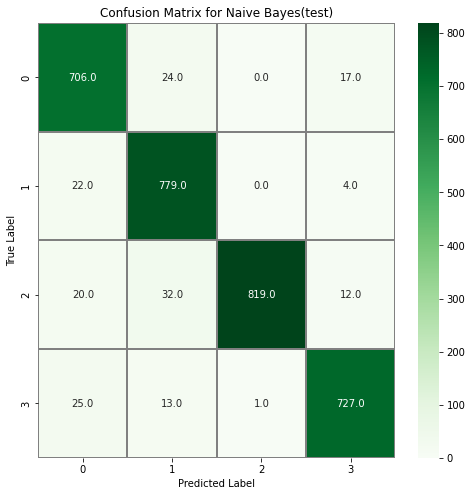

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       747
           1       0.92      0.97      0.94       805
           2       1.00      0.93      0.96       883
           3       0.96      0.95      0.95       766

    accuracy                           0.95      3201
   macro avg       0.95      0.95      0.95      3201
weighted avg       0.95      0.95      0.95      3201

Accuracy: 0.9468915963761324
--------------------------------------------------------------------
Suport Vector Classifier
Validation Set


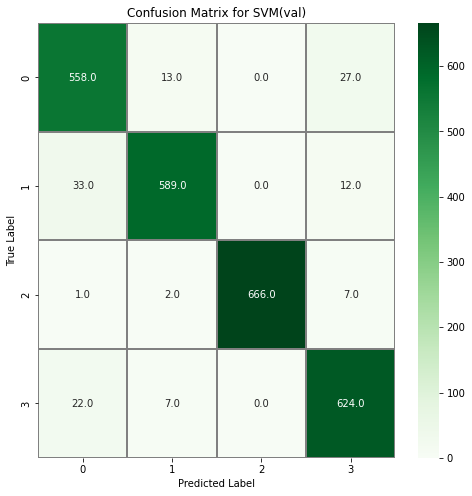

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       598
           1       0.96      0.93      0.95       634
           2       1.00      0.99      0.99       676
           3       0.93      0.96      0.94       653

    accuracy                           0.95      2561
   macro avg       0.95      0.95      0.95      2561
weighted avg       0.95      0.95      0.95      2561

Accuracy: 0.9515814135103475
*****************************
Test Set


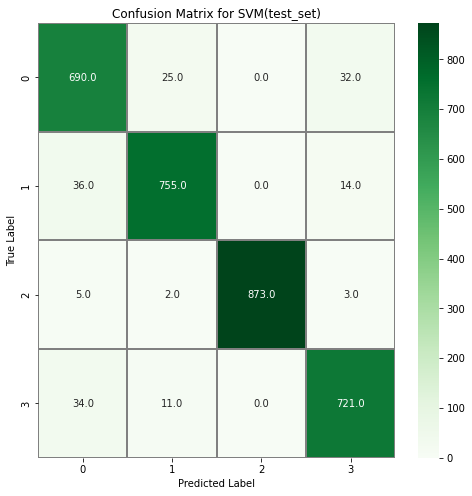

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       747
           1       0.95      0.94      0.94       805
           2       1.00      0.99      0.99       883
           3       0.94      0.94      0.94       766

    accuracy                           0.95      3201
   macro avg       0.95      0.95      0.95      3201
weighted avg       0.95      0.95      0.95      3201

Accuracy: 0.9493908153701968


In [74]:
file='final_summarized_BERT.csv'
data=pd.read_csv(file)
for i in range(len(data['Summaries'])):
    if pd.isna(data['Summaries'][i]):
        data['Summaries'][i]=data['Review'][i]
data.to_csv('final_summarized_BERT_replace.csv')
file='final_summarized_BERT_replace.csv'
classify_summarized(file)

# RESULTS (Accuracy)

### Unsummarized Text
<li> SVM: 99.40%</li>
<li> Naive Bayes: 98.49%</li>

### Summarized Text
<h4>T5</h4>
<li> SVM:97.65%</li>
<li> Naive Bayes: 97.68% </li>

<h4>BART</h4>
<li> SVM:97.38%</li>
<li> Naive Bayes: 97.389% </li>

<h4>BERT(using empty strings for NAN</h4>
<li> SVM:90.40%</li>
<li> Naive Bayes: 91.90% </li>

<h4>BERT(using empty strings for original review)</h4>
<li> SVM:94.93%</li>
<li> Naive Bayes: 94.68% </li>